<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/BEE-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
tf.version

<module 'tensorflow_core._api.v2.version' from '/tensorflow-2.1.0/python3.6/tensorflow_core/_api/v2/version/__init__.py'>

In [0]:
import matplotlib.pyplot as plt
def display_images(images,n):
  #print(images.shape)
  fig = plt.figure(figsize=(n*1.5,3))
  for i in range(n):
    img = images[i,:,:]
    plt.subplot(1,n,i+1)
    plt.imshow(img,cmap="binary")
    plt.axis("off")
  plt.show()    

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving honey-bee-annotated-images.zip to honey-bee-annotated-images.zip
User uploaded file "honey-bee-annotated-images.zip" with length 52950294 bytes


In [6]:
!unzip honey-bee-annotated-images.zip

Archive:  honey-bee-annotated-images.zip
  inflating: bee_data.csv            
  inflating: bee_imgs/bee_imgs/001_043.png  
  inflating: bee_imgs/bee_imgs/001_044.png  
  inflating: bee_imgs/bee_imgs/001_046.png  
  inflating: bee_imgs/bee_imgs/001_047.png  
  inflating: bee_imgs/bee_imgs/001_050.png  
  inflating: bee_imgs/bee_imgs/001_051.png  
  inflating: bee_imgs/bee_imgs/001_054.png  
  inflating: bee_imgs/bee_imgs/001_056.png  
  inflating: bee_imgs/bee_imgs/001_078.png  
  inflating: bee_imgs/bee_imgs/001_082.png  
  inflating: bee_imgs/bee_imgs/001_083.png  
  inflating: bee_imgs/bee_imgs/001_085.png  
  inflating: bee_imgs/bee_imgs/001_091.png  
  inflating: bee_imgs/bee_imgs/001_092.png  
  inflating: bee_imgs/bee_imgs/001_093.png  
  inflating: bee_imgs/bee_imgs/001_094.png  
  inflating: bee_imgs/bee_imgs/001_095.png  
  inflating: bee_imgs/bee_imgs/001_096.png  
  inflating: bee_imgs/bee_imgs/001_097.png  
  inflating: bee_imgs/bee_imgs/001_118.png  
  inflating: bee_imgs

In [0]:
img_test = keras.preprocessing.image.load_img('bee_imgs/bee_imgs/046_197.png')

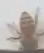

In [8]:
img_test

In [9]:
#%matplotlib inline
img_test.size

(44, 53)

In [0]:
img_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True,)

In [0]:
image_dim=28

In [12]:
train_generator = img_gen.flow_from_directory(
          './bee_imgs/', target_size=(image_dim, image_dim),
      batch_size=12,color_mode='grayscale',)

Found 5172 images belonging to 1 classes.


In [13]:
5172 % 12, 5172 /12

(0, 431.0)

In [0]:
(x_train,y_train)= train_generator.next()

In [15]:
x_train.shape,y_train.shape

((12, 28, 28, 1), (12, 1))

In [16]:
x_train[1,2,3,:]

array([0.28235295], dtype=float32)

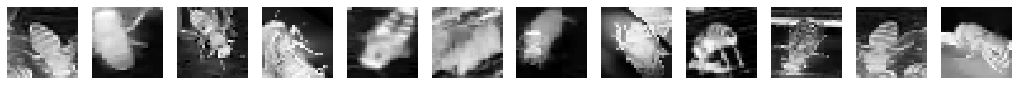

In [17]:
display_images(x_train.squeeze(),12)

In [18]:
type(x_train[0,0][0])

numpy.ndarray

In [19]:
x_train.shape

(12, 28, 28, 1)

In [20]:
tmp = x_train*2 - 1
tmp.shape

(12, 28, 28, 1)

In [0]:
batch_size=12

In [0]:
codings_size = 60

In [0]:
generator = keras.models.Sequential([
                                     keras.layers.Dense(100,activation="selu",input_shape=[codings_size]),
                                     #keras.layers.BatchNormalization(),
                                     keras.layers.Dense(150,activation="selu"),
                                     #keras.layers.BatchNormalization(),                                     
                                     keras.layers.Dense(150,activation="selu"),
                                     #keras.layers.BatchNormalization(),
                                     keras.layers.Dense(image_dim*image_dim,activation="sigmoid"),
                                     keras.layers.Reshape([image_dim,image_dim,1]),
])

In [0]:
init = keras.initializers.RandomNormal(stddev=0.02)
n_nodes = 128 * 7 * 7

In [0]:
generator = keras.models.Sequential([# foundation for 7x7 image
	keras.layers.Dense(n_nodes, kernel_initializer=init, input_shape=[codings_size]),
	keras.layers.LeakyReLU(alpha=0.2),
	keras.layers.Reshape((7, 7, 128)),
	# upsample to 14x14
	keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init),
	keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# upsample to 28x28
	keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init),
	keras.layers.BatchNormalization(),
	keras.layers.LeakyReLU(alpha=0.2),
	# output 28x28x1
	keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same', kernel_initializer=init)
])

In [35]:
tgen = generator(tf.random.normal(shape=[batch_size,codings_size]))
print(tgen.shape)

(12, 28, 28, 1)


In [0]:
discriminator = keras.models.Sequential([keras.layers.Conv2D(64,input_shape=[image_dim,image_dim,1],kernel_size=(2,2),strides=2,),
                                         keras.layers.Flatten(),
                                          keras.layers.Dense(150,activation="selu"),
                                      keras.layers.Dense(100,activation="selu"),
                                      keras.layers.Dense(1,activation="sigmoid"),
])

In [0]:
gan = keras.models.Sequential([generator,discriminator])

In [0]:
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=2e-4))
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=2e-4))

In [0]:
def train_gan(gan,train_generator,batch_size,codings_size,n_epochs=50,num_batches=100):
  generator,discriminator = gan.layers
  for epoch in range(n_epochs):
    for batch in range(num_batches):
      (X_batch,y_batch) = train_generator.next()
#      X_batch = X_batch_raw*2-1
      #print("Shape is",X_batch.shape)
      # Train discriminator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      generated_images = generator(noise)
      if (epoch+1) % 20 == 0 and batch==0:
        print("Epoch is",epoch+1,"GAN loss is",loss,"Discriminator loss is",disc_loss)
        display_images(tf.squeeze(generated_images),12)
        display_images(tf.squeeze(X_batch),12)
      X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
      y1 = tf.constant([[0.1]]*batch_size + [[0.9]]*batch_size)
      discriminator.trainable = True
      #disc_loss = discriminator.train_on_batch(X_fake_and_real,y1)
      disc_loss = discriminator.train_on_batch(generated_images,tf.constant([[0.1]]*batch_size))
      disc_loss += discriminator.train_on_batch(X_batch,tf.constant([[0.9]]*batch_size))
      disc_loss /= 2 
      # Train the generator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      y2 = tf.constant([[0.9]]*batch_size)
      discriminator.trainable = False
      loss = gan.train_on_batch(noise,y2)

Epoch is 20 GAN loss is 0.8040514 Discriminator loss is 0.68155437707901


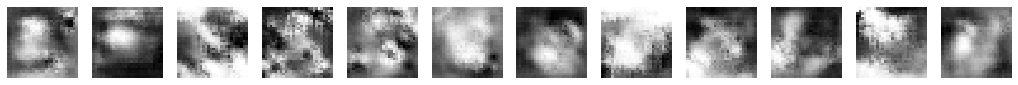

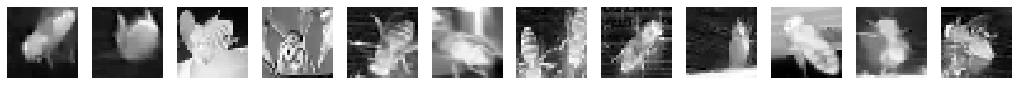

Epoch is 40 GAN loss is 0.9073536 Discriminator loss is 0.6661393642425537


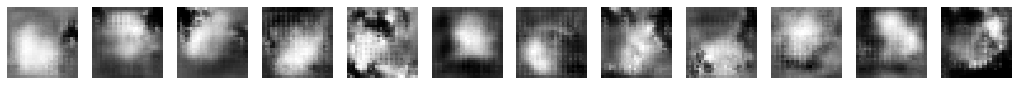

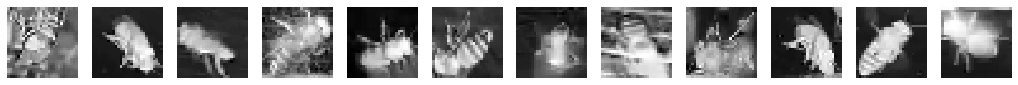

KeyboardInterrupt: ignored

In [44]:
train_gan(gan,train_generator,batch_size,codings_size,300,num_batches=100)